In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MFCC Audio

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split

def preprocess_audio(audio_file_path, max_length=500):
    try:

        audio, _ = librosa.load(audio_file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
        if mfccs.shape[1] < max_length:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_length]
        mfccs_normalized = (mfccs - np.mean(mfccs)) / np.std(mfccs)
        return mfccs_normalized
    except Exception as e:
        print(f"Error encountered while processing file: {audio_file_path}")
        return None

def load_data(directory):
    data = []
    labels = []
    for label, folder in enumerate(['aug_real', 'aug_fake']):
        folder_path = os.path.join(directory, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            features = preprocess_audio(file_path)
            if features is not None:
                data.append(features)
                labels.append(label)
    return np.array(data), np.array(labels)



Training data shape: (2297, 40, 500)
Training labels shape: (2297,)


MEL SPEC

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def preprocess_audio(audio_file_path, max_length=500):
    try:
        audio, _ = librosa.load(audio_file_path, sr=16000)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=40)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_resized = librosa.util.fix_length(mel_spec_db, size=max_length)
        mel_spec_normalized = (mel_spec_resized - np.mean(mel_spec_resized)) / np.std(mel_spec_resized)
        return mel_spec_normalized
    except Exception as e:
        print(f"Error encountered while processing file: {audio_file_path}")
        return None

def load_data(directory):
    data = []
    labels = []
    for label, folder in enumerate(['aug_real', 'aug_fake']):
        folder_path = os.path.join(directory, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            features = preprocess_audio(file_path)
            if features is not None:
                data.append(features)
                labels.append(label)
    return np.array(data), np.array(labels)

Chroma STFT

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def preprocess_audio(audio_file_path, max_length=500):
    try:
        audio, _ = librosa.load(audio_file_path, sr=16000)
        mel_spec = librosa.feature.chroma_stft(y=audio, sr=16000, n_chroma=40)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_resized = librosa.util.fix_length(mel_spec_db, size=max_length)
        mel_spec_normalized = (mel_spec_resized - np.mean(mel_spec_resized)) / np.std(mel_spec_resized)
        return mel_spec_normalized
    except Exception as e:
        print(f"Error encountered while processing file: {audio_file_path}")
        return None

def load_data(directory):
    data = []
    labels = []
    for label, folder in enumerate(['aug_real', 'aug_fake']):
        folder_path = os.path.join(directory, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            features = preprocess_audio(file_path)
            if features is not None:
                data.append(features)
                labels.append(label)
    return np.array(data), np.array(labels)

SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

dataset_dir = "/content/drive/MyDrive/speech"
train_dir = os.path.join(dataset_dir)
x_data, y_data = load_data(train_dir)



In [ ]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# Apply PCA to training and testing data
pca = PCA(n_components=18)
x_train_pca = pca.fit_transform(x_train_reshaped)
x_test_pca = pca.transform(x_test_reshaped)
svc = SVC(kernel='linear')
svc.fit(x_train_pca, y_train)

# Make predictions on the test set
svc_pred = svc.predict(x_test_pca)

# Calculate and print classification report
report = classification_report(y_test, svc_pred)
print("Support Vector Classifier Classification Report:")
print(report)

Support Vector Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       232
           1       0.83      0.82      0.83       228

    accuracy                           0.83       460
   macro avg       0.83      0.83      0.83       460
weighted avg       0.83      0.83      0.83       460



CNN-LSTM

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split

# ... (the preprocess_audio and load_data functions remain the same)

dataset_dir = "/content/drive/MyDrive/speech"
train_dir = os.path.join(dataset_dir)
x_data, y_data = load_data(train_dir)
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

# Define the model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(40, 500)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(units=64, return_sequences=True),
    LSTM(units=64),
    Dense(units=128, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Epoch 1/10
58/58 [==============================] - 8s 58ms/step - loss: 0.6902 - accuracy: 0.5259 - val_loss: 0.6744 - val_accuracy: 0.5326
Epoch 2/10
58/58 [==============================] - 3s 43ms/step - loss: 0.5520 - accuracy: 0.7153 - val_loss: 0.4768 - val_accuracy: 0.7957
Epoch 3/10
58/58 [==============================] - 2s 28ms/step - loss: 0.3700 - accuracy: 0.8541 - val_loss: 0.3983 - val_accuracy: 0.8152
Epoch 4/10
58/58 [==============================] - 2s 29ms/step - loss: 0.3259 - accuracy: 0.8710 - val_loss: 0.3415 - val_accuracy: 0.8522
Epoch 5/10
58/58 [==============================] - 2s 28ms/step - loss: 0.2907 - accuracy: 0.8862 - val_loss: 0.3077 - val_accuracy: 0.8630
Epoch 6/10
58/58 [==============================] - 2s 28ms/step - loss: 0.2344 - accuracy: 0.8993 - val_loss: 0.3236 - val_accuracy: 0.8457
Epoch 7/10
58/58 [==============================] - 2s 28ms/step - loss: 0.1919 - accuracy: 0.9211 - val_loss: 0.3214 - val_accuracy: 0.8717
Epoch 8/10
58

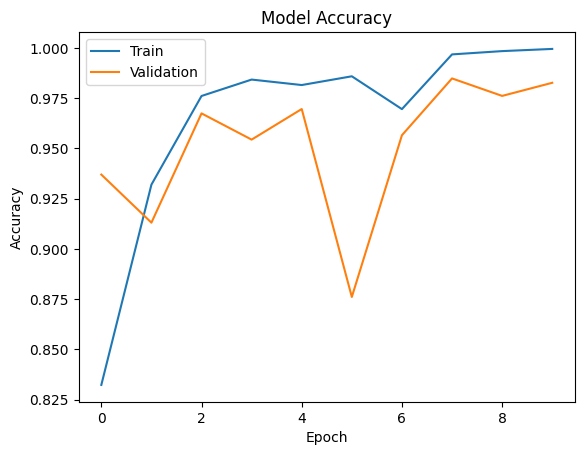

15/15 [==============================] - 2s 18ms/step


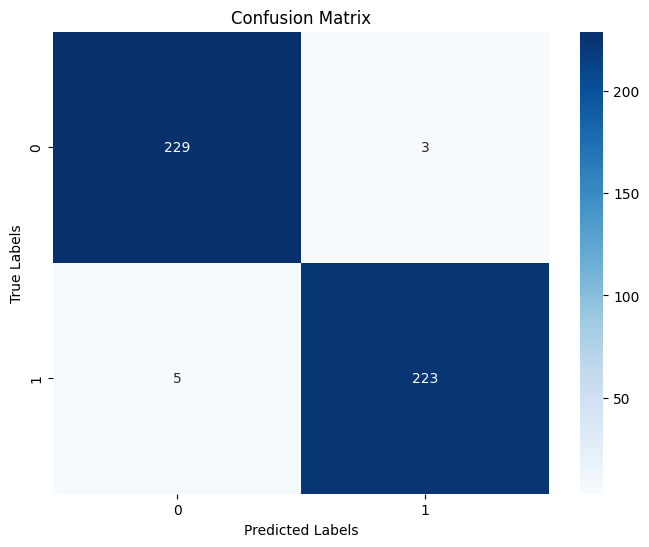

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot epoch vs accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Compute predictions
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5)

# Compute confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Test

In [ ]:
import librosa
import numpy as np

def predict(audio_file_path, model, threshold=0.5):
    # Preprocess the audio file
    processed_audio = preprocess_audio(audio_file_path)
    if processed_audio is not None:
        # Reshape the input for the model
        input_data = np.expand_dims(processed_audio, axis=0)
        # Make predictions
        prediction = model.predict(input_data)
        # Determine class based on threshold
        if prediction >= threshold:
            return "Fake"
        else:
            return "Real"
    else:
        return None

# Example usage
audio_file_path = "/content/drive/MyDrive/speech/aug_real/shifted_Athigama Asapatura Ambalayum.wav"
prediction = predict(audio_file_path, model)
print("Prediction:", prediction)

1/1 [==============================] - 2s 2s/step
Prediction: Real


Save Model

In [ ]:
# Save the model
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
